# Projectile motion
Let's apply our ODE solvers to some problems involving balls and projectiles.

The `integrators.py` file from section 11 is used here (and named `ode.py`).

In [1]:
import numpy as np
import ode

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Projectile with linear air-resistance
Linear drag force

$$
\mathbf{F}_1 = -b_1 \mathbf{v}
$$

Equations of motion with force due to gravity $\mathbf{g} = -g \hat{\mathbf{e}}_y$

\begin{align}
\frac{d\mathbf{r}}{dt} &= \mathbf{v}\\
\frac{d\mathbf{v}}{dt} &= - g \hat{\mathbf{e}}_y -\frac{b_1}{m} \mathbf{v} 
\end{align}

Bring into standard ODE form for

$$
\frac{d\mathbf{y}}{dt} = \mathbf{f}(t, \mathbf{y})
$$

as

$$
\mathbf{y} = \begin{pmatrix}
x\\
y\\
v_x\\
v_y
\end{pmatrix}, \quad
\mathbf{f} = \begin{pmatrix}
v_x\\
v_y\\
-\frac{b_1}{m} v_x\\
-g -\frac{b_1}{m} v_y
\end{pmatrix}
$$

(Based on Wang 2016, Ch 3.3.1)

In [3]:
def simulate(v0, h=0.01, b1=0.2, g=9.81, m=0.5):
    
    def f(t, y):
        # y = [x, y, vx, vy]
        return np.array([y[2], y[3], -b1/m * y[2], -g - b1/m * y[3]])

    vx, vy = v0
    t = 0
    positions = []
    y = np.array([0, 0, vx, vy], dtype=np.float64)
    
    while y[1] >= 0:
        positions.append([t, y[0], y[1]])  # record t, x and y
        y[:] = ode.rk4(y, f, t, h)
        t += h
        
    return np.array(positions)

def initial_v(v, theta):
    x = np.deg2rad(theta)
    return v * np.array([np.cos(x), np.sin(x)])

In [4]:
r = simulate(initial_v(200, 30), h=0.01, b1=1)

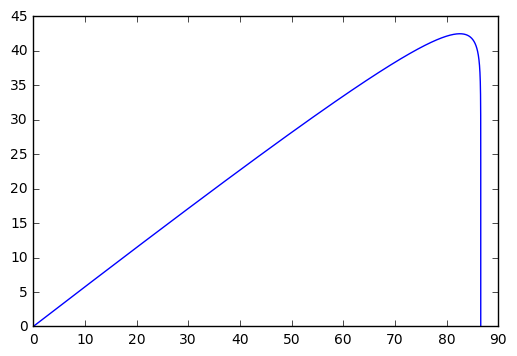

In [5]:
plt.plot(r[:, 1], r[:, 2])

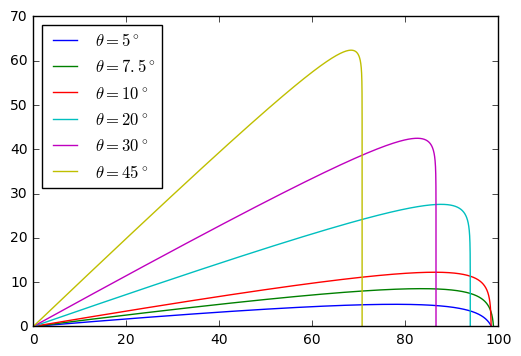

In [6]:
for angle in (5, 7.5, 10, 20, 30, 45):
    r = simulate(initial_v(200, angle), h=0.01, b1=1)
    plt.plot(r[:, 1], r[:, 2], label=r"$\theta = {}^\circ$".format(angle))
plt.legend(loc="best")

## Simple Baseball physics

- quadratic air resistance (with velocity-dependent drag coefficient)
- Magnus force due to spin


### Quadratic air resistance
Occurs at high Reynolds numbers, i.e., turbulent flow. Only approximate:

$$
\mathbf{F}_2 = -b_2 v \mathbf{v}
$$

### Magnus effect 

**Magnus effect**: airflow is changed around a spinning object. The Magnus force is

$$
\mathbf{F}_M = \alpha \boldsymbol{\omega} \times \mathbf{v}
$$

where $\boldsymbol{\omega}$ is the ball's angular velocity in rad/s (e.g., 200/s for a baseball).

For a sphere the proportionality constant $\alpha$ can be written

$$
\mathbf{F}_M = \frac{1}{2} C_L \rho A \frac{v}{\omega} \boldsymbol{\omega} \times \mathbf{v}
$$

where $C_L$ is the lift coefficient, $\rho$ the air density, $A$ the ball's cross section. (Advantage of defining $C_L$ this way: when spin and velocity are perpendicular, the Magnus force is simply $F_M = \frac{1}{2} C_L \rho A v^2$.)

$C_L$ is mainly a function of the *spin parameter*

$$
S = \frac{r\omega}{v}
$$

with the radius $r$ of the ball. In general we write

$$
\mathbf{F}_M = \frac{1}{2} C_L  \frac{\rho A r}{S} \boldsymbol{\omega} \times \mathbf{v}
$$

For a baseball, experimental data show approximately a power law dependence of $C_L$ on $S$

$$
C_L = 0.62 \times S^{0.7}
$$

All together:

\begin{align}
\mathbf{F}_M &= \alpha\ \boldsymbol{\omega} \times \mathbf{v}\\
v &= \sqrt{\mathbf{v}}\\
S &= \frac{r\omega}{v}\\
C_L &= 0.62 \times S^{0.7}\\
\alpha &= \frac{1}{2} C_L  \frac{\rho A r}{S}
\end{align}


### Equations of motion

\begin{align}
\frac{d\mathbf{r}}{dt} &= \mathbf{v}\\
\frac{d\mathbf{v}}{dt} &= -g \hat{\mathbf{e}}_y \mathbf{v} -\frac{b_2}{m} v \mathbf{v} + \alpha\ \boldsymbol{\omega} \times \mathbf{v}\\
\end{align}

(quadratic drag $-\frac{b_2}{m} v \mathbf{v}$ included.)


### Baseball simulation 

Implement the full baseball equations of motions:
- gravity $a_\text{gravity}$
- quadratic drag $a_\text{drag}$
- Magnus effect $a_\text{Magnus}$

For the cross product you can look at [numpy.cross()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cross.html).

In [7]:
def C_L(S):
    return 0.62 * S**0.7

def simulate_baseball(v0, omega=200.*np.array([0,1,1]), r0=np.array([0, 2.]),
                      h=0.01, b2=0.0013, g=9.81, r=0.07468/2, m=0.14883):

    omega = np.asarray(omega)
    
    # all SI units (kg, m)
    R_homeplate = 18.4
    
    rho = 1.225  # kg/m^3
    domega = np.linalg.norm(omega)
    A = np.pi*r**2
    rhoArm = rho * A * r / m
    
    a_gravity = np.array([0, -g, 0])

    def f(t, y):
        # y = [x, y, z, vx, vy, vz]
        v = y[3:]
        dv = np.linalg.norm(v)
        S = r*domega/dv
        a_magnus = 0.5 * C_L(S) * rhoArm / S * np.cross(omega, v)
        a_drag = -b2/m * dv * v
        a = a_gravity + a_drag + a_magnus
        return np.array([y[3], y[4], y[5],
                         a[0], a[1], a[2]])

    x0, y0 = r0
    vx, vy = v0
    t = 0
    positions = []
    # initialize 3D!
    y = np.array([x0, y0, 0, vx, vy, 0], dtype=np.float64)
    
    while y[0] < R_homeplate and y[1] >= 0.2:
        positions.append([t, y[0], y[1], y[2]])  # record t, x and y, z
        y[:] = ode.rk4(y, f, t, h)
        t += h
        
    return np.array(positions)


#### Simulate throws 

Simulate baseball throw for initial velocity $\mathbf{v} = (30\,\text{m/s}, 0)$.

Plot x vs y and x vs z (to see curving).

Try out different spins; a good value is $\boldsymbol{\omega} = 200\,\text{rad/s} \times (0, 1, 1)$.

Simulate the baseball throw with
- almost no spin: $\omega = 0.001 \times (0, 0, 1)$  (our code does not handle $\omega = 0$ gracefully...)
- full upward spin: $\omega = 200 \times (0, 0, 1)$
- sideways spin: $\omega = 200 \times (0, 1, 1)$

In [8]:
r = simulate_baseball([30, 0], omega=0.001*np.array([0,0,1]))
rz = simulate_baseball([30, 0], omega=200.*np.array([0,0,1]))
rzy = simulate_baseball([30, 0], omega=200.*np.array([0,1,1]))

#### Plotting

Plot the three scenarios in 2D planes: x-y (side view) and x-z (top view).

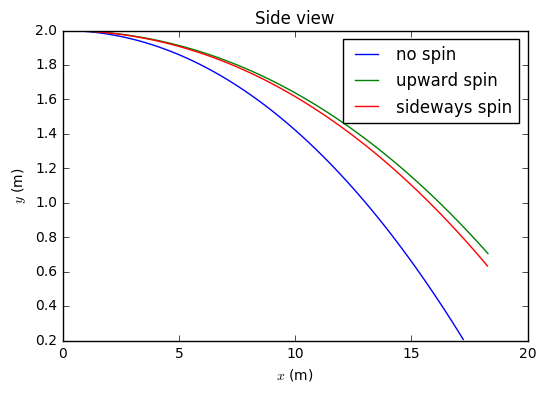

In [9]:
idx = 2  # y
plt.plot(r[:,1], r[:,idx], label="no spin")
plt.plot(rz[:,1], rz[:,idx], label="upward spin")
plt.plot(rzy[:,1], rzy[:,idx], label="sideways spin")
plt.xlabel("$x$ (m)")
plt.ylabel("$y$ (m)")
plt.legend(loc="best")
plt.title("Side view")

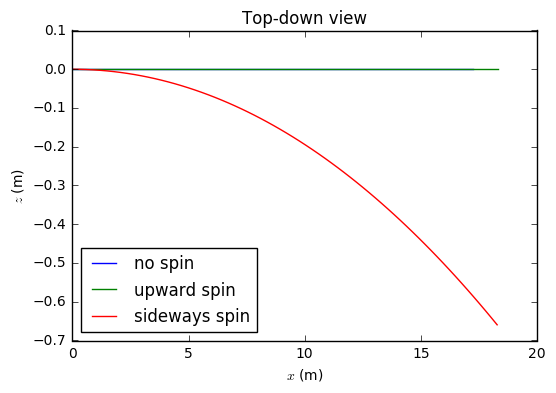

In [10]:
idx = 3  # y
plt.plot(r[:,1], r[:,idx], label="no spin")
plt.plot(rz[:,1], rz[:,idx], label="upward spin")
plt.plot(rzy[:,1], rzy[:,idx], label="sideways spin")
plt.xlabel("$x$ (m)")
plt.ylabel("$z$ (m)")
plt.legend(loc="best")
plt.title("Top-down view")

#### 3D plot
Use simple `matplotlib` 3D plot. (BONUS: Make it work with vpython)

If we use the [`notebook` backend for matplotlib](http://ipython.readthedocs.io/en/stable/interactive/plotting.html) then we will be able to interactively rotate our [matplotlib 3D graphics](http://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html). (Note: If this does not seem to work, disable adblockers and allow javascript on the page.)

In [21]:
%matplotlib notebook

<IPython.core.display.Javascript object>


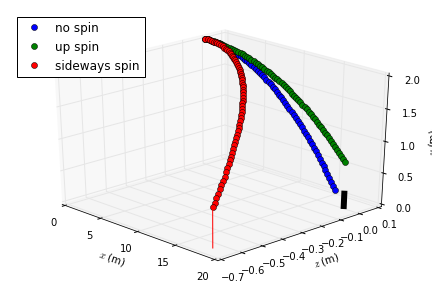

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(r[:,1], r[:,3], r[:,2], 'o', label="no spin")
ax.plot(rz[:,1], rz[:,3], rz[:,2], 'o', label="up spin")
ax.plot(rzy[:,1], rzy[:,3], rzy[:,2], 'o', label="sideways spin")

# hand of the catcher, 0.2m above homeplate
ax.plot([18.4, 18.4], [0, 0], [0, 0.2], color="black", lw=6)

# drop line for last point
x,y,z = rzy[-1, 1:]
ax.plot([x,x], [z,z], [y,0], color="red")

ax.set_xlabel("$x$ (m)")
ax.set_ylabel("$z$ (m)")
ax.set_zlabel("$y$ (m)")
ax.legend(loc="upper left", numpoints=1)
ax.figure.tight_layout()

## Reynolds number

$$
\text{Re} = \frac{\rho v L}{\mu}\\
\text{Re} > 2300\quad\text{flow turbulent}
$$

* density $\rho$: air  1.275 kg/m^3 (kilograms per cubic meter)
* fluid viscosity $\mu$: air 1.845×10^-5 Pa s (pascal seconds) (at 25 °C)

(from Wolfram Alpha)

In [13]:
rho_air = 1.275    # kg/m^3
mu_air = 1.845e-5  # Pa s

In [14]:
L = 0.05  # m
v = 200   # m/s

In [15]:
def ReynoldsNumber(v, L, rho=rho_air, mu=mu_air):
    return rho*v*L/mu

In [16]:
ReynoldsNumber(20, L)

69105.69105691057

This means that we really should be using quadratic air resistance for the projectile.